In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from LDA import LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [10]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [11]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [12]:
#our LDA
clf = LDA(n_components=4)
clf.fit(X_train, y_train)
lda_transformed_X_train= clf.transform(X_train)
lda_X_test = clf.transform(X_test)


print(lda_X_test.shape, lda_transformed_X_train.shape)

(5000, 4) (10000, 4)


In [13]:
#PCA using sklearn
pca = PCA(n_components=5)
pca_transformed_X_train= pca.fit_transform(X_train, y_train)
pca_X_test_transformed = pca.transform(X_test)

In [52]:

def KNN_accuracy(X_train,y_train,X_test,y_test):
    """
    returns accuracy of KNN classifier

    Inputs:
    - X_train: Training data features (numpy array or pandas DataFrame)
    - y_train: Training data labels (numpy array or pandas Series)
    - X_test: Testing data features (numpy array or pandas DataFrame)
    - y_test: Testing data labels (numpy array or pandas Series)

    Output:
    - accuracy_score: the accuracy of the KNN classifier on the test data.
    It is calculated as the ratio of correctly predicted instances to the total number of instances.(float)


    """
    neigh = KNeighborsClassifier(n_neighbors=21)
    neigh.fit(X_train, y_train)
    predictions = (neigh.predict(X_test))

    accuracy_score = np.sum(predictions== y_test)/len(y_test)
    return accuracy_score



In [54]:
KNN_accuracy(lda_transformed_X_train,y_train, lda_X_test,y_test)

0.8134

In [15]:
#answers what proportion of predicted positives  is truly positive?
#should this be removed mayb???
def KNN_precision(X_train, y_train, X_test, y_test):
    """
    Returns the precision of a KNN classifier.

    Inputs:
    - X_train: Training data features (numpy array or pandas DataFrame)
    - y_train: Training data labels (numpy array or pandas Series)
    - X_test: Testing data features (numpy array or pandas DataFrame)
    - y_test: Testing data labels (numpy array or pandas Series)

    Output:
    - precision: Float representing the precision of the KNN classifier on the test data.
                 It is calculated as the ratio of true positives to the sum of true positives and false positives.

    """
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    predictions = neigh.predict(X_test)

    # Calculate True Positives and False Positives
    true_positives = np.sum((predictions == y_test) & (predictions == 1))
    false_positives = np.sum((predictions == 1) & (y_test == 0))

    # Calculate Precision from formula: TP/(TP+FP) 
    precision = true_positives / (true_positives + false_positives)
    return precision


In [19]:
#should this be removed?
def KNN_recall(X_train, y_train, y_test,X_test):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    predictions = neigh.predict(X_test)

    #TP/(TP+FN)
    true_positives = np.sum((predictions == y_test) & (predictions == 1))
    false_negative = np.sum((predictions == 0) & (y_test == 1))
    recall = true_positives / (true_positives + false_negative)
    return recall

    


In [17]:
recall_value = KNN_recall(X_train, y_train, X_test)
precision_value = KNN_precision(X_train, y_train, X_test, y_test)
accuracy_value = KNN_accuracy(X_train, y_train, X_test, y_test)

In [ ]:
KNN_recall(lda_transformed_X_train, y_train, lda_X_test)

0.9927007299270073

In [ ]:
KNN_precision(lda_transformed_X_train,)

In [ ]:
#KNN_accuracy(pca_transformed_X_train,y_train,pca_X_test_transformed )
KNN_accuracy(lda_transformed_X_train,y_train,lda_X_test,y_test )

0.7956

In [57]:
def cross_val_regular(X,y,n,cv):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X, y)
    scores = cross_val_score(neigh, X, y, cv=cv)
    return scores

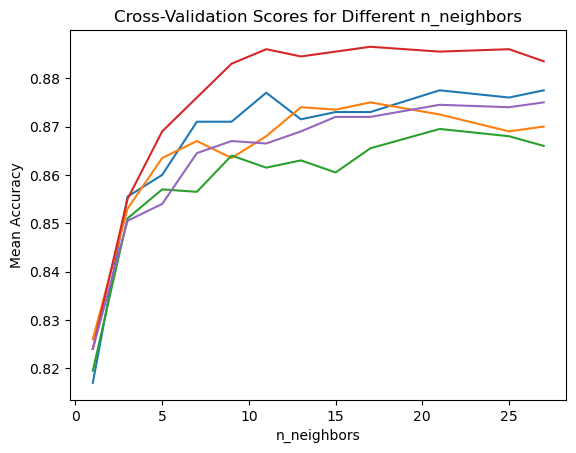

In [58]:
n_values = [1, 3,5,7,9,11,13,15,17,21,25,27]
cv=5
def cross_val_plot(X_train,y_train,n,cv):
    all_scores = []
    for n in n_values:
        scores = cross_val_regular(X_train, y_train, n, cv)
        all_scores.append(scores)
        # Plotting
    plt.plot(n_values, all_scores, marker='none')
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.show()


#cross_val_plot(X_train,y_train, n_values, cv)
cross_val_plot(lda_transformed_X_train,y_train,n_values,cv)

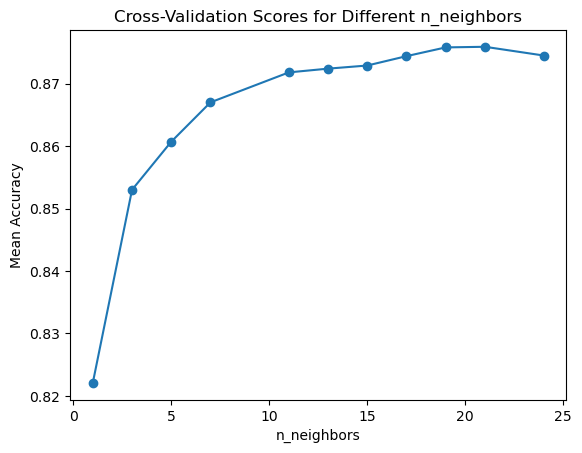

In [29]:
n_values=[1,3,5,7,11,13,15,17,19,21,23]
def cross_val_mean(X_train, y_train, n, cv):
    classifier = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return np.mean(scores)  # Return the mean score

def cross_val_plot(X_train, y_train, n_values, cv):
    all_scores = [cross_val_mean(X_train, y_train, n, cv) for n in n_values]

    # Plotting
    plt.plot(n_values, all_scores, marker='o')
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.show()


#cross_val_plot(X_train, y_train, n_values, cv=5)
cross_val_plot(lda_transformed_X_train,y_train,n_values,cv)


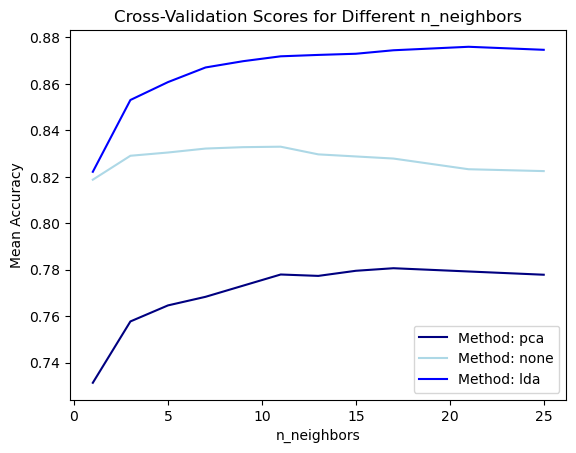

In [51]:
n_value=[1,3,5,7,9,11,13,15,17,21,25]

def cross_val_mean(X_train, y_train, n, cv):
    classifier = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return np.mean(scores)  # Return the mean score

def cross_val_plot(data_sets, n_values, cv):
    Methods = ['pca', 'none', 'lda']
    colors = ["navy", "lightblue", 'blue']
    for i, (X_train, y_train) in enumerate(data_sets):
        method_name = Methods[i]
        all_scores = [cross_val_mean(X_train, y_train, n, cv) for n in n_values]
        plt.plot(n_values, all_scores, marker='none', label=f'Method: {method_name}', color=colors[i])

    # Plotting
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.legend()
    plt.savefig('cross_val_pca_lda_none.png')
    plt.show()

# Assuming pca_transformed_X_train, y_train, and another set of X_train, y_train are your datasets
data_sets = [(pca_transformed_X_train, y_train), (X_train, y_train), (lda_transformed_X_train, y_train)]

# Also, assuming n_values is a list of hyperparameter values to be tested
cross_val_plot(data_sets, n_value, cv=5)


In [34]:
def lda_multi(n_components):
    clf = LDA(n_components)
    clf.fit(X_train, y_train)
    lda_transformed_X_train= clf.transform(X_train)
    lda_X_test = clf.transform(X_test)
    return lda_transformed_X_train, y_train
    

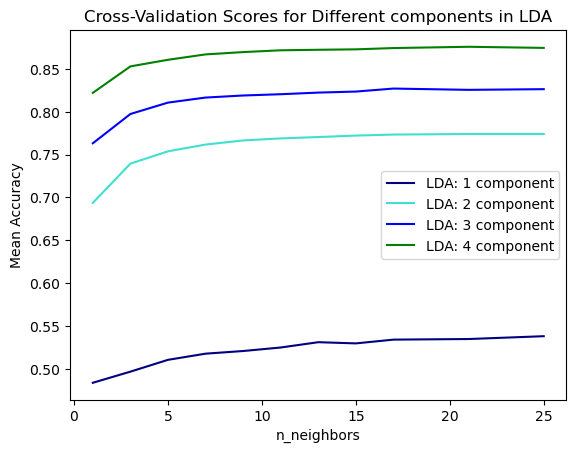

In [50]:
def cross_val_mean(X_train, y_train, n, cv):
    classifier = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return np.mean(scores)  # Return the mean score

def cross_val_plot(data_sets, n_values, cv):
    Methods = ['1 component', '2 component', '3 component','4 component']
    colors = ['navy', 'turquoise', 'blue','green']
    for i, (X_train, y_train) in enumerate(data_sets):
        method_name = Methods[i]
        all_scores = [cross_val_mean(X_train, y_train, n, cv) for n in n_values]
        plt.plot(n_values, all_scores, marker='none', label=f'LDA: {method_name}',color=colors[i])

    # Plotting
    plt.title('Cross-Validation Scores for Different components in LDA')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.legend()
    plt.savefig('cross_val_diff_lda_plot.png')
    plt.show()

data_sets = [(lda_multi(1)), (lda_multi(2)), (lda_multi(3)),(lda_multi(4))]

cross_val_plot(data_sets,n_value,cv=5)
